In [1]:
!pip install -U funasr -q
!pip install -U modelscope -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.7/693.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.8/283.8 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 24.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.0 MB/s eta 0:00:00
     ━━━

In [49]:
import os
import torch
from funasr import AutoModel
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import soundfile as sf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [34]:
# Set the cache directory
torch.hub.set_dir('/content/cache')

In [35]:
model = AutoModel(model="fsmn-vad", model_revision="v2.0.4", device="cuda")

2024-06-20 10:06:58,041 - modelscope - INFO - Use user-specified model revision: v2.0.4


ckpt: /root/.cache/modelscope/hub/iic/speech_fsmn_vad_zh-cn-16k-common-pytorch/model.pt


In [114]:
def vad_inference(audio_path):
    res = model.generate(input=audio_path) # Generate speech activity detection
    return res[0]['value']  # Assuming timestamps are stored in the first element

def convert_to_timestamps(timestamps):
    output_segments = []
    start = 0
    for timestamp in timestamps:
        new_start = timestamp[0]/10**3
        new_end = timestamp[1]/10**3
        dict = {'speech': [new_start, new_end]}
        output_segments.append(dict)

    return output_segments

def input_type_for_visualize_timestamps(timestamps):
    # Convert results to list of dictionaries with start and end times in seconds
    speech_timestamps = [{'start': segment[0]/10**3, 'end': segment[1]/10**3} for segment in timestamps]
    return speech_timestamps

# Function to visualize speech timestamps
def visualize_timestamps(speech_timestamps):
    fig, ax = plt.subplots(figsize=(12, 2))
    for timestamp in speech_timestamps:
        ax.plot([timestamp['start'], timestamp['end']], [1, 1], color='black', linewidth=1)
    ax.set_xlim([0, max(timestamp['end'] for timestamp in speech_timestamps)])
    ax.set_ylim([0.5, 1.5])
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.set_title('Speech Activity Detection')
    plt.show()

# Function to print speech timestamps
def print_timestamps(speech_timestamps):
    for idx, timestamp in enumerate(speech_timestamps):
        start_time = timestamp['start']
        end_time = timestamp['end']
        duration = end_time - start_time
        print(f"Start: {start_time:.2f}s, End: {end_time:.2f}s, Duration: {duration:.2f}s")

def parse_annotations_file(file_path):
    annotated_segments = []

    with open(file_path, 'r') as f:
        lines = f.readlines()
        # print(lines)

    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespace including '\n'
        parts = line.split()
        if len(parts) == 3:
            start_time = float(parts[0].rstrip('s'))  # Remove 's' from seconds
            end_time = float(parts[1].rstrip('s'))  # Remove 's' from seconds
            label = parts[2]

            if label == 'speech':  # Correcting typo 'speach' to 'speech'
                annotated_segments.append({'speech': [start_time, end_time]})
            elif label == 'notspeech':
                annotated_segments.append({'notspeech': [start_time, end_time]})
            else:
                # Handle other labels if needed
                pass

    return annotated_segments

def evaluate_vad(output_segments, annotated_segments):
    # Create a list of tuples for both output and annotated segments
    output_intervals = [(seg['speech'][0], seg['speech'][1], 'speech') for seg in output_segments]
    annotated_intervals = []
    for seg in annotated_segments:
        if 'speech' in seg:
            annotated_intervals.append((seg['speech'][0], seg['speech'][1], 'speech'))
        elif 'notspeech' in seg:
            annotated_intervals.append((seg['notspeech'][0], seg['notspeech'][1], 'notspeech'))

    # Create a timeline of 0.01s resolution for evaluation
    resolution = 0.01
    max_time = max(max(end for _, end, _ in annotated_intervals), max(end for _, end, _ in output_intervals))
    time_points = [i * resolution for i in range(int(max_time / resolution) + 1)]

    # Initialize ground truth and predictions
    y_true = ['notspeech'] * len(time_points)
    y_pred = ['notspeech'] * len(time_points)

    # Mark the true labels in y_true
    for start, end, label in annotated_intervals:
        for i in range(int(start / resolution), int(end / resolution)):
            y_true[i] = label

    # Mark the predicted labels in y_pred
    for start, end, label in output_intervals:
        for i in range(int(start / resolution), int(end / resolution)):
            y_pred[i] = label

    # Convert labels to binary format for evaluation
    y_true_binary = [1 if label == 'speech' else 0 for label in y_true]
    y_pred_binary = [1 if label == 'speech' else 0 for label in y_pred]

    # Calculate evaluation metrics
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    }

def visualize_comparison(output_segments, annotated_segments):
    fig, ax = plt.subplots(figsize=(15, 4))

    # Visualize annotated segments
    for seg in annotated_segments:
        if 'speech' in seg:
            ax.plot([seg['speech'][0], seg['speech'][1]], [2, 2], color='blue', linewidth=2, label='Annotated Speech' if 'Annotated Speech' not in ax.get_legend_handles_labels()[1] else "")
        elif 'notspeech' in seg:
            ax.plot([seg['notspeech'][0], seg['notspeech'][1]], [2, 2], color='red', linewidth=2, label='Annotated Non-Speech' if 'Annotated Non-Speech' not in ax.get_legend_handles_labels()[1] else "")

    # Visualize output segments
    for seg in output_segments:
        ax.plot([seg['speech'][0], seg['speech'][1]], [1, 1], color='green', linewidth=2, label='Predicted Speech' if 'Predicted Speech' not in ax.get_legend_handles_labels()[1] else "")

    ax.set_xlim([0, max(max(seg['speech'][1] for seg in output_segments), max(max(s.values())[1] for s in annotated_segments))])
    ax.set_ylim([0.5, 2.5])
    ax.set_xlabel('Time (s)')
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['Predicted', 'Annotated'])
    ax.set_title('Speech Activity Detection: Annotated vs Predicted')
    ax.legend(loc='upper right')

    plt.show()

def visualize_comparison_stacked(output_segments, annotated_segments):
    fig, ax = plt.subplots(figsize=(15, 6))

    # Define colors
    colors = {
        'annotated_speech': 'blue',
        'annotated_nonspeech': 'red',
        'predicted_speech': 'green'
    }

    # Add annotated segments to the plot
    for seg in annotated_segments:
        if 'speech' in seg:
            ax.broken_barh([(seg['speech'][0], seg['speech'][1] - seg['speech'][0])], (2, 1), facecolors=colors['annotated_speech'], edgecolor='none')
        elif 'notspeech' in seg:
            ax.broken_barh([(seg['notspeech'][0], seg['notspeech'][1] - seg['notspeech'][0])], (2, 1), facecolors=colors['annotated_nonspeech'], edgecolor='none')

    # Add predicted segments to the plot
    for seg in output_segments:
        ax.broken_barh([(seg['speech'][0], seg['speech'][1] - seg['speech'][0])], (1, 1), facecolors=colors['predicted_speech'], edgecolor='none')

    # Add labels, legend, and limits
    ax.set_xlim(0, max(max(seg['speech'][1] for seg in output_segments), max(max(s.values())[1] for s in annotated_segments)))
    ax.set_ylim(0, 3)
    ax.set_xlabel('Time (s)')
    ax.set_yticks([1.5, 2.5])
    ax.set_yticklabels(['Predicted', 'Annotated'])
    ax.set_title('Speech Activity Detection: Annotated vs Predicted')

    # Create a custom legend
    annotated_speech_patch = mpatches.Patch(color=colors['annotated_speech'], label='Annotated Speech')
    annotated_nonspeech_patch = mpatches.Patch(color=colors['annotated_nonspeech'], label='Annotated Non-Speech')
    predicted_speech_patch = mpatches.Patch(color=colors['predicted_speech'], label='Predicted Speech')
    ax.legend(handles=[annotated_speech_patch, annotated_nonspeech_patch, predicted_speech_patch], loc='upper right')

    plt.show()

def add_noise(audio_path, noise_path, snr):
    # Load audio and noise
    audio, sr = sf.read(audio_path)
    noise, _ = sf.read(noise_path)

    # Truncate or pad noise to match audio length
    if len(noise) > len(audio):
        noise = noise[:len(audio)]
    else:
        noise = np.pad(noise, (0, len(audio) - len(noise)), 'wrap')

    # Calculate signal power and noise power
    audio_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum(noise ** 2) / len(noise)

    # Calculate required noise level to achieve the desired SNR
    required_noise_power = audio_power / (10 ** (snr / 10))
    noise_scaling_factor = np.sqrt(required_noise_power / noise_power)
    noisy_audio = audio + noise_scaling_factor * noise

    return noisy_audio, sr

def run_vad_on_noisy_audio(audio_path, noise_path, snr):
    noisy_audio, sr = add_noise(audio_path, noise_path, snr)
    noisy_audio_path = "noisy_audio.wav"
    save_audio(noisy_audio, sr, noisy_audio_path)
    output = vad_inference(noisy_audio_path)
    return output

def save_audio(audio, sr, path):
    sf.write(path, audio, sr)

def vad_performance_vs_SNR(low_SNR, high_SNR, SNR_jump):

    snr_levels = [dp for dp in range(5, 25)]  # SNR levels in dB
    results = []

    for snr in snr_levels:
        output = run_vad_on_noisy_audio(audio_path, noise_path, snr)
        output_segments = convert_to_timestamps(output)
        metrics = evaluate_vad(output_segments, annotated_segments)
        results.append((snr, metrics))

    # Plot results
    snrs = [result[0] for result in results]
    precisions = [result[1]['precision'] for result in results]
    recalls = [result[1]['recall'] for result in results]
    f1_scores = [result[1]['f1_score'] for result in results]
    accuracies = [result[1]['accuracy'] for result in results]

    plt.figure(figsize=(10, 6))
    plt.plot(snrs, precisions, label='Precision')
    plt.plot(snrs, recalls, label='Recall')
    plt.plot(snrs, f1_scores, label='F1-Score')
    plt.plot(snrs, accuracies, label='Accuracy')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Metrics')
    plt.title('VAD Performance vs SNR')
    plt.legend()
    plt.grid(True)
    plt.show()

In [121]:
# Example usage with your own audio file
audio_path = '/content/marathi-01.wav' # Audio file path
noise_path = '/content/rain-noise.wav'
label_path = '/content/marathi-01.txt'

rtf_avg: 0.014: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


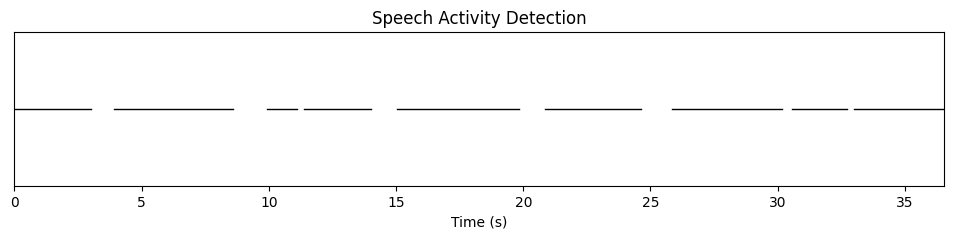

Start: 0.00s, End: 3.02s, Duration: 3.02s
Start: 3.91s, End: 8.58s, Duration: 4.67s
Start: 9.93s, End: 11.12s, Duration: 1.19s
Start: 11.40s, End: 14.02s, Duration: 2.62s
Start: 15.05s, End: 19.84s, Duration: 4.79s
Start: 20.84s, End: 24.64s, Duration: 3.80s
Start: 25.83s, End: 30.15s, Duration: 4.32s
Start: 30.58s, End: 32.71s, Duration: 2.13s
Start: 32.99s, End: 36.55s, Duration: 3.56s


In [122]:
timestamps = vad_inference(audio_path)
output_segments = convert_to_timestamps(timestamps)
input_visualize = input_type_for_visualize_timestamps(timestamps)
visualize_timestamps(input_visualize)
print_timestamps(input_visualize)
annotated_segments = parse_annotations_file(label_path) # Formate the label properly

{'precision': 0.8478405315614618, 'recall': 0.973302822273074, 'f1_score': 0.90625, 'accuracy': 0.8556588299617277}


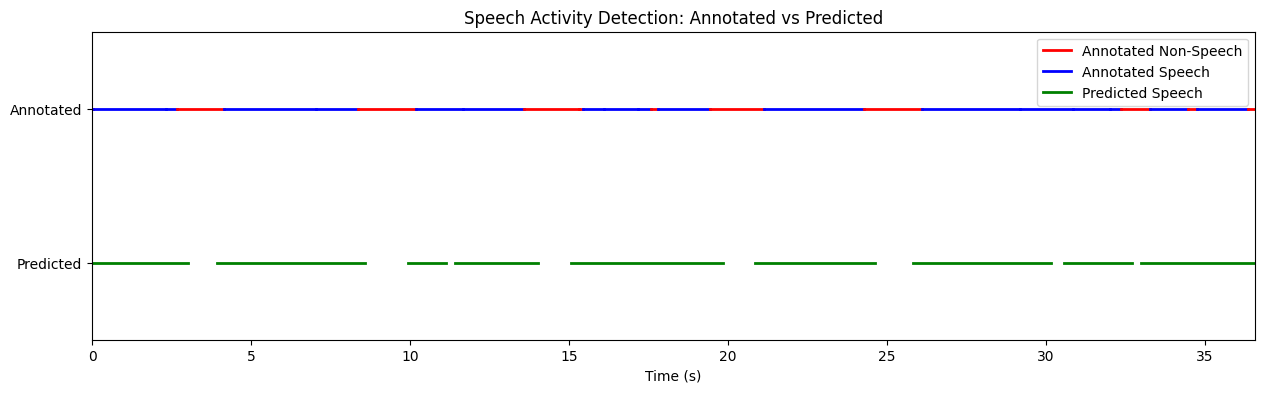

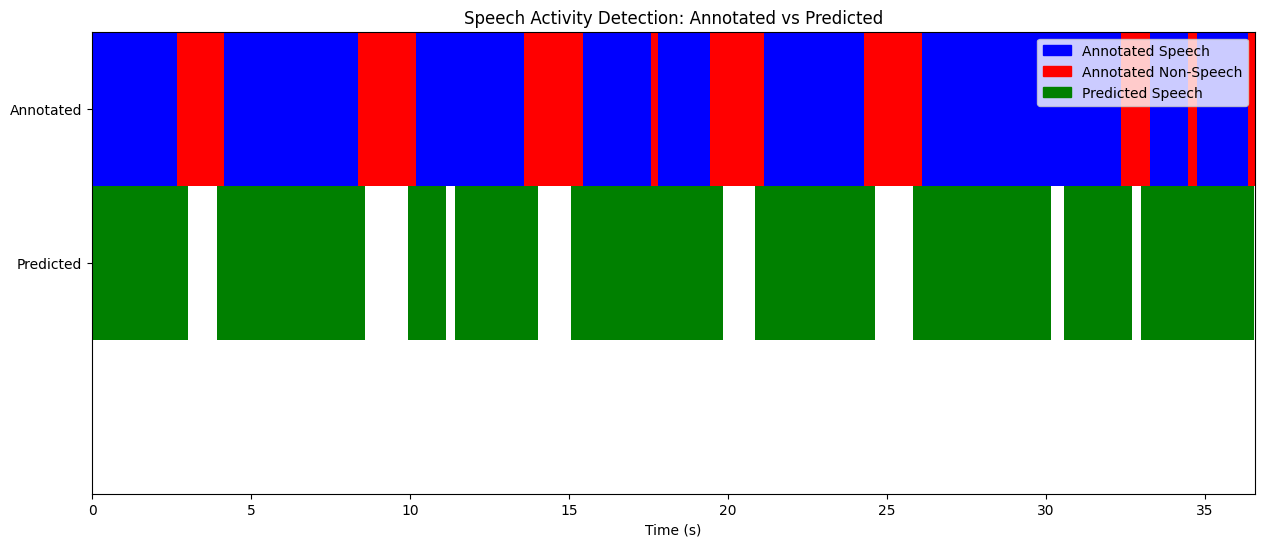

In [123]:
evaluation_results = evaluate_vad(output_segments, annotated_segments)
print(evaluation_results)
visualize_comparison(output_segments, annotated_segments)
visualize_comparison_stacked(output_segments, annotated_segments)

rtf_avg: 0.014: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


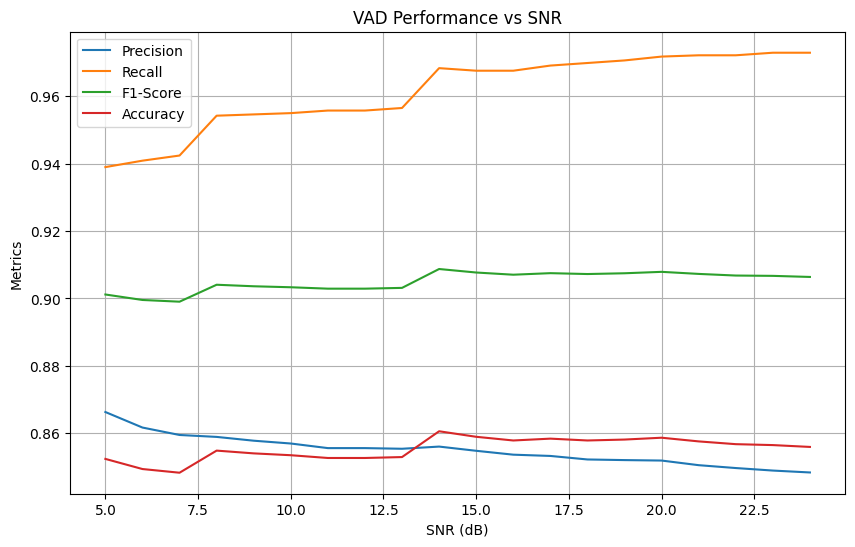

In [124]:
vad_performance_vs_SNR(5, 25, 0.5) # Visualization of the continous SNR with the corresponiding vad perferomance